## Import Packages

In [17]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data Preparation

In [19]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (DataFrame): Pandas DataFrame containing image paths and labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('img_path')]
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('level')]

        if self.transform:
            image = self.transform(image)

        return image, label


In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [21]:
df = pd.read_csv(r'D:\projects\DRFundus\data\trainLabels_cropped.csv',index_col=0)
df.drop('Unnamed: 0',axis=1)
img_path = 'D:\\projects\\DRFundus\\data\\resized_train_cropped\\resized_train_cropped\\'
df['img_path'] = img_path + df['image'] + '.jpeg'
df.head()

,Unnamed: 0,image,level,img_path
0,0,10_left,0,D:\projects\DRFundus\data\resized_train_croppe...
1,1,10_right,0,D:\projects\DRFundus\data\resized_train_croppe...
2,2,13_left,0,D:\projects\DRFundus\data\resized_train_croppe...
3,3,13_right,0,D:\projects\DRFundus\data\resized_train_croppe...
4,4,15_left,1,D:\projects\DRFundus\data\resized_train_croppe...


In [22]:
train_df, remaining_df = train_test_split(df, test_size=0.3, stratify=df['level'])
valid_df, test_df = train_test_split(remaining_df, test_size=0.6, stratify=remaining_df['level'])

print("Training set size:", len(train_df))
print("Validation set size:", len(valid_df))
print("Test set size:", len(test_df))

Training set size: 24575
Validation set size: 4213
Test set size: 6320


In [23]:
train_dataset = DiabeticRetinopathyDataset(dataframe=train_df, transform=transform)
valid_dataset = DiabeticRetinopathyDataset(dataframe=valid_df, transform=transform)
test_dataset = DiabeticRetinopathyDataset(dataframe=test_df, transform=transform)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Modeling

### Fine Tune

In [30]:
from torchvision.models import efficientnet_b0

# Load the EfficientNet model (you can choose different variants like b0, b1, etc.)
model = efficientnet_b0(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes
num_classes = 5
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Unfreeze the classifier head
for param in model.classifier.parameters():
    param.requires_grad = True

# Rest of the code remains mostly the same
optimizer = torch.optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-5},  # Lower learning rate for pre-trained layers
    {'params': model.classifier.parameters(), 'lr': 1e-3}  # Higher learning rate for the classifier head
])

#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()


d:\projects\DRFundus\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\projects\DRFundus\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Scratch

In [28]:
from torchvision.models import efficientnet_b0

# Load the EfficientNet model (you can choose different variants like b0, b1, etc.)
modelscratch = efficientnet_b0(pretrained=False)


# Modify the final layer to match the number of classes
num_classes = 5
modelscratch.classifier[1] = nn.Linear(modelscratch.classifier[1].in_features, num_classes)

optimizer = torch.optim.AdamW(modelscratch.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()


d:\projects\DRFundus\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\projects\DRFundus\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training

In [31]:
def train(num_epochs, model, train_loader, valid_loader, optimizer, criterion, device=None, patience=5, min_delta=0.01):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    best_accuracy = 0.0
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    model.to(device)

    # Initialize lists to store loss, accuracy, and ROC AUC
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    roc_auc_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0
        all_preds = []
        all_labels = []
        all_probs = []  # Store predicted probabilities for ROC AUC

        # Add tqdm to track training progress
        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_train += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(torch.softmax(outputs.detach(), dim=1).cpu().numpy())  # Collect probabilities for ROC AUC

        epoch_loss = running_loss / total_train
        epoch_acc = running_corrects.double() / total_train
        train_precision = precision_score(all_labels, all_preds, average='weighted')
        train_recall = recall_score(all_labels, all_preds, average='weighted')
        train_f1 = f1_score(all_labels, all_preds, average='weighted')

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Training Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}')

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        total_val = 0
        val_preds = []
        val_labels = []
        val_probs = []  # Store predicted probabilities for ROC AUC

        # Add tqdm to track validation progress
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                total_val += labels.size(0)

                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(torch.softmax(outputs.detach(), dim=1).cpu().numpy())  # Collect probabilities for ROC AUC

        val_loss = val_running_loss / total_val
        val_acc = val_running_corrects.double() / total_val
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        # Calculate ROC AUC score
        if len(set(val_labels)) > 1:  # ROC AUC requires at least two classes
            roc_auc = roc_auc_score(val_labels, np.array(val_probs), multi_class='ovr')
        else:
            roc_auc = float('nan')  # If only one class, ROC AUC is not applicable
        roc_auc_scores.append(roc_auc)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
        print(f'ROC AUC Score: {roc_auc:.4f}')

        # Save the best model
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), r'D:\projects\DRFundus\model\best_efficientnet_model.pth')
        else:
            epochs_without_improvement += 1

        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    print(f'Best Validation Accuracy: {best_accuracy:.4f}')

    # Plot the loss, accuracy, and ROC AUC score
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(18, 6))

    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot ROC AUC scores
    plt.subplot(1, 3, 3)
    plt.plot(epochs, roc_auc_scores, 'g-', label='ROC AUC Score')
    plt.title('ROC AUC Score')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


Training Epoch 1/10: 100%|██████████| 768/768 [06:39<00:00,  1.92it/s]


Training Loss: 0.8338 Acc: 0.7344
Training Precision: 0.6269, Recall: 0.7344, F1 Score: 0.6499


Validation Epoch 1/10: 100%|██████████| 132/132 [01:01<00:00,  2.14it/s]


Validation Loss: 0.7776 Acc: 0.7408
Validation Precision: 0.6369, Recall: 0.7408, F1 Score: 0.6591
ROC AUC Score: 0.7419


Training Epoch 2/10: 100%|██████████| 768/768 [04:39<00:00,  2.75it/s]


Training Loss: 0.7796 Acc: 0.7399
Training Precision: 0.6465, Recall: 0.7399, F1 Score: 0.6650


Validation Epoch 2/10: 100%|██████████| 132/132 [00:47<00:00,  2.79it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.7768 Acc: 0.7484
Validation Precision: 0.6529, Recall: 0.7484, F1 Score: 0.6746
ROC AUC Score: 0.7445


Training Epoch 3/10: 100%|██████████| 768/768 [04:42<00:00,  2.72it/s]


Training Loss: 0.7679 Acc: 0.7425
Training Precision: 0.6539, Recall: 0.7425, F1 Score: 0.6714


Validation Epoch 3/10: 100%|██████████| 132/132 [00:50<00:00,  2.62it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.7590 Acc: 0.7458
Validation Precision: 0.6487, Recall: 0.7458, F1 Score: 0.6689
ROC AUC Score: 0.7585


Training Epoch 4/10: 100%|██████████| 768/768 [04:51<00:00,  2.63it/s]


Training Loss: 0.7634 Acc: 0.7429
Training Precision: 0.6596, Recall: 0.7429, F1 Score: 0.6726


Validation Epoch 4/10: 100%|██████████| 132/132 [00:47<00:00,  2.78it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.7634 Acc: 0.7455
Validation Precision: 0.6500, Recall: 0.7455, F1 Score: 0.6610
ROC AUC Score: 0.7633


Training Epoch 5/10: 100%|██████████| 768/768 [04:36<00:00,  2.77it/s]


Training Loss: 0.7603 Acc: 0.7455
Training Precision: 0.6661, Recall: 0.7455, F1 Score: 0.6769


Validation Epoch 5/10: 100%|██████████| 132/132 [00:47<00:00,  2.77it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.7538 Acc: 0.7489
Validation Precision: 0.6531, Recall: 0.7489, F1 Score: 0.6726
ROC AUC Score: 0.7665


Training Epoch 6/10: 100%|██████████| 768/768 [06:42<00:00,  1.91it/s]


Training Loss: 0.7544 Acc: 0.7459
Training Precision: 0.6708, Recall: 0.7459, F1 Score: 0.6761


Validation Epoch 6/10: 100%|██████████| 132/132 [01:11<00:00,  1.85it/s]


Validation Loss: 0.7536 Acc: 0.7486
Validation Precision: 0.6820, Recall: 0.7486, F1 Score: 0.6871
ROC AUC Score: 0.7665


Training Epoch 7/10: 100%|██████████| 768/768 [05:30<00:00,  2.32it/s]


Training Loss: 0.7543 Acc: 0.7447
Training Precision: 0.6610, Recall: 0.7447, F1 Score: 0.6762


Validation Epoch 7/10: 100%|██████████| 132/132 [00:50<00:00,  2.59it/s]


Validation Loss: 0.7531 Acc: 0.7460
Validation Precision: 0.6487, Recall: 0.7460, F1 Score: 0.6759
ROC AUC Score: 0.7679


Training Epoch 8/10: 100%|██████████| 768/768 [05:03<00:00,  2.53it/s]


Training Loss: 0.7496 Acc: 0.7467
Training Precision: 0.6813, Recall: 0.7467, F1 Score: 0.6786


Validation Epoch 8/10: 100%|██████████| 132/132 [00:49<00:00,  2.64it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.7525 Acc: 0.7522
Validation Precision: 0.6612, Recall: 0.7522, F1 Score: 0.6777
ROC AUC Score: 0.7656
Early stopping triggered after 8 epochs.
Best Validation Accuracy: 0.0000


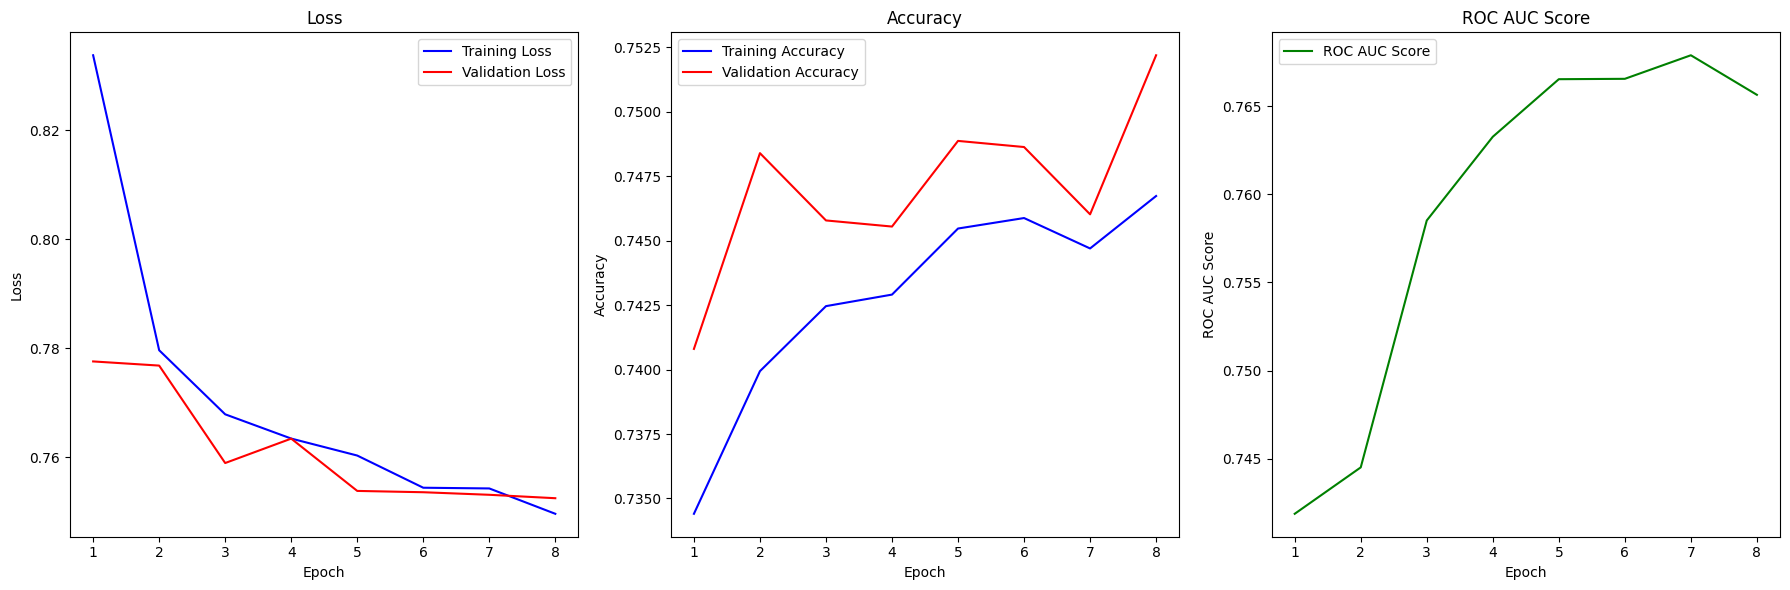

In [32]:
train(10, model, train_loader, valid_loader, optimizer, criterion, device)

In [29]:
train(10, modelscratch, train_loader, valid_loader, optimizer, criterion, device)

Training Epoch 1/10: 100%|██████████| 768/768 [07:20<00:00,  1.74it/s]


Training Loss: 0.9022 Acc: 0.7267
Training Precision: 0.5629, Recall: 0.7267, F1 Score: 0.6209


Validation Epoch 1/10: 100%|██████████| 132/132 [01:00<00:00,  2.19it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.9343 Acc: 0.7318
Validation Precision: 0.5539, Recall: 0.7318, F1 Score: 0.6223
ROC AUC Score: 0.5981


Training Epoch 2/10: 100%|██████████| 768/768 [08:07<00:00,  1.57it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Loss: 0.8557 Acc: 0.7349
Training Precision: 0.5903, Recall: 0.7349, F1 Score: 0.6228


Validation Epoch 2/10: 100%|██████████| 132/132 [01:01<00:00,  2.15it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.8775 Acc: 0.7349
Validation Precision: 0.5400, Recall: 0.7349, F1 Score: 0.6226
ROC AUC Score: 0.6225


Training Epoch 3/10: 100%|██████████| 768/768 [09:57<00:00,  1.29it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Loss: 0.8453 Acc: 0.7349
Training Precision: 0.5618, Recall: 0.7349, F1 Score: 0.6228


Validation Epoch 3/10: 100%|██████████| 132/132 [01:22<00:00,  1.61it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.8966 Acc: 0.7349
Validation Precision: 0.5400, Recall: 0.7349, F1 Score: 0.6226
ROC AUC Score: 0.6366


Training Epoch 4/10: 100%|██████████| 768/768 [08:44<00:00,  1.46it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Loss: 0.8345 Acc: 0.7348
Training Precision: 0.5771, Recall: 0.7348, F1 Score: 0.6234


Validation Epoch 4/10: 100%|██████████| 132/132 [00:56<00:00,  2.34it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Loss: 0.8485 Acc: 0.7349
Validation Precision: 0.5400, Recall: 0.7349, F1 Score: 0.6226
ROC AUC Score: 0.6341


Training Epoch 5/10: 100%|██████████| 768/768 [09:11<00:00,  1.39it/s]
d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Loss: 0.8191 Acc: 0.7344
Training Precision: 0.5824, Recall: 0.7344, F1 Score: 0.6243


Validation Epoch 5/10:  40%|████      | 53/132 [00:36<00:54,  1.45it/s]


KeyboardInterrupt: 

## Testing

In [33]:
model = efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load(r'D:\projects\DRFundus\model\best_efficientnet_model.pth'))
model.to(device)
model.eval()

d:\projects\DRFundus\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\projects\DRFundus\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_38420\640277659.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flip

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Test loop
model.eval()  # Set the model to evaluation mode
test_running_corrects = 0
total_test = 0
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Track correct predictions and the total number of samples
        test_running_corrects += torch.sum(preds == labels.data)
        total_test += labels.size(0)

        # Collect predictions and labels for metrics
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate metrics for the test set
test_acc = test_running_corrects.double() / total_test
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

# Print the test results
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}')

Test Accuracy: 0.7472
Test Precision: 0.6546, Recall: 0.7472, F1 Score: 0.6679


d:\projects\DRFundus\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
